# Composite score of accuracy and robustness/consistency, across methods

## Imports and settings

In [18]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# =========================
# Settings
# =========================

datasets = ["ADP", "PBMC", "MSB", "MBC"]
methods = ["BayesPrism", "SCADEN", "SCDC"]

display_names = {
    "rawSN": "snRNA",
    "degSN": "snRNA (-DEG)",
    "degOtherSN": "-DEG Other Datasets",
    "degIntSN": "-DEG Int.",
    "degRandSN": "-Random Genes",
    "pcaSN": "PCA·LS",
    "degPCA_SN": "PCA·LS (-DEG)",
    "scvi_LSshift_SN": "scVI·LS",
    "degScviLSshift_SN": "scVI·LS (-DEG)",
    "scviSN": "scVIcond",
    "degScviSN": "scVIcond (-DEG)",
    "degIntAllSN": "snRNA All (-DEG Int.)",
}

# Palettes & transform names
display_palette = {
    "snRNA": "rosybrown",
    "PCA·LS": "#2ca02c",
    "scVI·LS": "darkorange",
    "scVIcond": "#9467bd",
    "snRNA (-DEG)": "lightcoral",
    "PCA·LS (-DEG)": "#98df8a",
    "scVI·LS (-DEG)": "sandybrown",
    "scVIcond (-DEG)": "#c5b0d5",
    "-DEG Other Datasets": "sandybrown",
    "-DEG Int.": "tomato",
    "-Random Genes": "chocolate",
    "snRNA All (-DEG Int.)": "m",
}

# Visual encoding for methods (marker per method)
method_markers = {"BayesPrism": "o", "SCADEN": "s", "SCDC": "^"}

# Utility to standardize transform ids (only needed for degpcaSN legacy)
def _fix_transform_ids(df, col="Transform"):
    if col in df.columns:
        df[col] = df[col].str.replace("degpcaSN", "degPCA_SN")
    else:
        df.index = df.index.str.replace("degpcaSN", "degPCA_SN")
        df.columns = df.columns.str.replace("degpcaSN", "degPCA_SN")
    return df


## Load data

In [20]:
# =========================
# Load data for ALL methods
# =========================

# Per-method containers
eval_dfs_by_method = {}          # {method: {dataset: eval_df}}
donor_consistency_by_method = {} # {method: donor_consistency_df}
transform_consistency_by_method = {}  # {method: transform_cosine_matrix_df}

# 1) Simulation evaluation files (Pearson/RMSE) per dataset & method
for method in methods:
    per_ds = {}
    for ds in datasets:
        fp = os.path.join("..", "results", ds, f"evaluation_{method}_{ds}.csv")
        if not os.path.exists(fp):
            raise FileNotFoundError(f"Missing evaluation file for {ds}: {fp}")
        df = pd.read_csv(fp)
        df = _fix_transform_ids(df, col="Transform")   # <-- add this line
        per_ds[ds] = df
    eval_dfs_by_method[method] = per_ds

# 2) Real data consistency (per-donor pairwise cosine, and transform x transform cosine) per method
for method in methods:
    donor_fp = os.path.join("..", "results", "Real_ADP", f"donor_{method}_pairwise_consistency.csv")
    transf_fp = os.path.join("..", "results", "Real_ADP", f"transform_{method}_consistency_cosine.csv")

    if not os.path.exists(donor_fp):
        raise FileNotFoundError(f"Missing donor consistency for {method}: {donor_fp}")
    if not os.path.exists(transf_fp):
        raise FileNotFoundError(f"Missing transform consistency for {method}: {transf_fp}")

    donor_df = pd.read_csv(donor_fp)
    transf_df = pd.read_csv(transf_fp, index_col=0)

    donor_df = _fix_transform_ids(donor_df, col="Transform")
    transf_df = _fix_transform_ids(transf_df)  # fixes both index & columns

    donor_consistency_by_method[method] = donor_df
    transform_consistency_by_method[method] = transf_df

# Quick sanity-check prints
print("Simulation eval shapes:")
for method in methods:
    sizes = {ds: df.shape for ds, df in eval_dfs_by_method[method].items()}
    print(f"  {method}: {sizes}")

print("Donor consistency (rows) by method:", {m: donor_consistency_by_method[m].shape for m in methods})
print("Transform cosine matrices by method:", {m: transform_consistency_by_method[m].shape for m in methods})


Simulation eval shapes:
  BayesPrism: {'ADP': (14000, 4), 'PBMC': (14000, 4), 'MSB': (11000, 4), 'MBC': (14000, 4)}
  SCADEN: {'ADP': (14000, 4), 'PBMC': (14000, 4), 'MSB': (11000, 4), 'MBC': (14000, 4)}
  SCDC: {'ADP': (14000, 4), 'PBMC': (14000, 4), 'MSB': (11000, 4), 'MBC': (14000, 4)}
Donor consistency (rows) by method: {'BayesPrism': (792, 3), 'SCADEN': (792, 3), 'SCDC': (792, 3)}
Transform cosine matrices by method: {'BayesPrism': (12, 12), 'SCADEN': (12, 12), 'SCDC': (12, 12)}


**Simulation eval shapes**

Each evaluation_{DS}.csv has one row per (SampleID × CellType × Transform). For ADP, ~79 000 rows means ADP had ~7 182 sample–cell pairs × 11 transforms ≈ 79 000. PBMC, MSB, MBC similarly line up with their numbers of pseudobulk samples and transforms.

**Donor consistency**

We have 726 rows in donor_pairwise_consistency.csv. That equals 11 transforms × C( n_donors, 2 ) donor–donor pairs (for Real_ADP, n_donors = 12 → C(12,2)=66; 66×11=726).

**Transform consistency**

A square 11×11 matrix, one cosine for each (transform_i, transform_j) pair among the 11 transforms.

## Normalization, calculation and combining

In [21]:
def process_results(eval_dfs):
    norm_summaries = []

    for ds, df in eval_dfs.items():

        if "RMSE_NonRemoved" in df.columns:
            df["RMSE"] = df["RMSE_NonRemoved"]
            df["Pearson"] = df["Pearson_NonRemoved"]
        elif "RMSE_RemovedOnly" in df.columns:
            df["RMSE"] = df["RMSE_RemovedOnly"]
            df["Pearson"] = df["Pearson_RemovedOnly"]

        # 1) find the full Pearson & RMSE ranges
        p_min, p_max = df["Pearson"].min(), df["Pearson"].max()
        r_min, r_max = df["RMSE"].min(), df["RMSE"].max()

        # 2) normalize each sample‐row
        df = df.copy()
        df["pearson_norm"] = (df["Pearson"] - p_min) / (p_max - p_min)
        # invert RMSE so “higher is better,” then scale
        df["rmse_norm"] = (r_max - df["RMSE"]) / (r_max - r_min)

        # 3) now collapse to one summary per transform by *median*
        grp = (
            df.groupby("Transform")
            .agg(
                pearson_norm=("pearson_norm", "mean"),
                rmse_norm=("rmse_norm", "mean"),
                n_samples=("Pearson", "size"),
            )
            .reset_index()
        )
        grp["Dataset"] = ds
        norm_summaries.append(grp)

    norm_df = pd.concat(norm_summaries, ignore_index=True)

    # in this case, the controls are not comparable so we remove.
    sim_df = norm_df[~norm_df["Transform"].isin(["sc_raw", "sn_raw"])]
    # 1) collapse across datasets
    sim_df = sim_df.groupby("Transform")[["pearson_norm", "rmse_norm"]].mean()

    # 2) combine into one accuracy score
    sim_df["accuracy_score"] = sim_df[["pearson_norm", "rmse_norm"]].mean(axis=1)
    sim_df["Transform"] = sim_df.index.map(display_names)
    sim_df.index = sim_df["Transform"]
    # done – one row per transform
    print(sim_df.sort_values("accuracy_score", ascending=False))

    return sim_df

In [22]:
# Compute normalized Pearson/RMSE accuracy summary per method
sim_by_method = {}  # {method: DataFrame indexed by display transform name}

for method in methods:
    sim_df = process_results(eval_dfs_by_method[method])
    # ensure display names are present for coloring/labels
    sim_df["Transform"] = sim_df.index
    sim_df["Method"] = method
    sim_by_method[method] = sim_df

# Quick peek
{k: v.shape for k, v in sim_by_method.items()}

                       pearson_norm  rmse_norm  accuracy_score  \
Transform                                                        
snRNA (-DEG)               0.848829   0.758612        0.803721   
-DEG Other Datasets        0.845518   0.735686        0.790602   
-DEG Int.                  0.828808   0.722410        0.775609   
scVIcond                   0.817896   0.704213        0.761055   
PCA·LS (-DEG)              0.809787   0.705427        0.757607   
scVIcond (-DEG)            0.799463   0.699928        0.749696   
PCA·LS                     0.799142   0.691795        0.745469   
-Random Genes              0.801898   0.673815        0.737856   
snRNA                      0.799779   0.673696        0.736737   
scVI·LS                    0.791779   0.663344        0.727562   
scVI·LS (-DEG)             0.759797   0.624577        0.692187   
snRNA All (-DEG Int.)      0.606929   0.594986        0.600958   

                                   Transform  
Transform                   

{'BayesPrism': (12, 5), 'SCADEN': (12, 5), 'SCDC': (12, 5)}

In [23]:
# =========================
# Consistency (Real_ADP) per method
# =========================
consistency_by_method = {}  # {method: DataFrame indexed by display transform name}

for method in methods:
    donor_consistency = donor_consistency_by_method[method].copy()
    transform_consistency = transform_consistency_by_method[method].copy()

    # Flatten transform matrix to a long table (exclude self similarity)
    rows = []
    for t1 in transform_consistency.index:
        for t2 in transform_consistency.columns:
            if t1 == t2:
                continue
            rows.append({"Transform": t1, "Cosine": transform_consistency.loc[t1, t2]})
    transform_long = pd.DataFrame(rows)

    # Min–max normalize cosine values in each table
    d_min, d_max = donor_consistency["Cosine"].min(), donor_consistency["Cosine"].max()
    donor_consistency["cosine_norm"] = (donor_consistency["Cosine"] - d_min) / (d_max - d_min)

    t_min, t_max = transform_long["Cosine"].min(), transform_long["Cosine"].max()
    transform_long["cosine_norm"] = (transform_long["Cosine"] - t_min) / (t_max - t_min)

    # Collapse to one mean normalized consistency per transform (donor and transform axes)
    donor_score = (
        donor_consistency.groupby("Transform")["cosine_norm"]
        .mean()
        .reset_index(name="donor_score")
    )
    transform_score = (
        transform_long.groupby("Transform")["cosine_norm"]
        .mean()
        .reset_index(name="transform_score")
    )

    # Merge; overall consistency = mean of the two
    consistency_df = donor_score.merge(transform_score, on="Transform")
    consistency_df["consistency_score"] = consistency_df[["donor_score", "transform_score"]].mean(axis=1)

    # Map to display names and index by them
    consistency_df["Display"] = consistency_df["Transform"].map(display_names)
    consistency_df = consistency_df.dropna(subset=["Display"]).copy()
    consistency_df.index = consistency_df["Display"]
    consistency_df["Method"] = method

    # Keep only what's needed for plotting merge later
    consistency_df = consistency_df[["consistency_score", "Method"]].rename_axis("Transform")
    consistency_by_method[method] = consistency_df

# Quick peek
{k: v.shape for k, v in consistency_by_method.items()}

{'BayesPrism': (12, 2), 'SCADEN': (12, 2), 'SCDC': (12, 2)}

In [24]:
# =========================
# Combine per-method accuracy and consistency
# =========================
combo_all = []

for method in methods:
    acc = sim_by_method[method][["accuracy_score"]].copy()
    acc.index.name = "Transform"
    cons = consistency_by_method[method][["consistency_score"]].copy()

    # Inner-join on display transform name
    merged = acc.join(cons, how="inner")
    merged["Method"] = method
    merged["Display"] = merged.index  # display label used for colors
    combo_all.append(merged.reset_index())

combo_all = pd.concat(combo_all, ignore_index=True)

# Sanity checks
print(combo_all.Method.value_counts())
print(combo_all.head())

# Sort for deterministic plotting order
combo_all = combo_all.sort_values(["Display", "Method"]).reset_index(drop=True)

Method
BayesPrism    12
SCADEN        12
SCDC          12
Name: count, dtype: int64
               Transform  accuracy_score  consistency_score      Method  \
0  snRNA All (-DEG Int.)        0.600958           0.441753  BayesPrism   
1              -DEG Int.        0.775609           0.864467  BayesPrism   
2    -DEG Other Datasets        0.790602           0.795826  BayesPrism   
3          PCA·LS (-DEG)        0.757607           0.499077  BayesPrism   
4          -Random Genes        0.737856           0.821114  BayesPrism   

                 Display  
0  snRNA All (-DEG Int.)  
1              -DEG Int.  
2    -DEG Other Datasets  
3          PCA·LS (-DEG)  
4          -Random Genes  


## X and Y composite score scatter

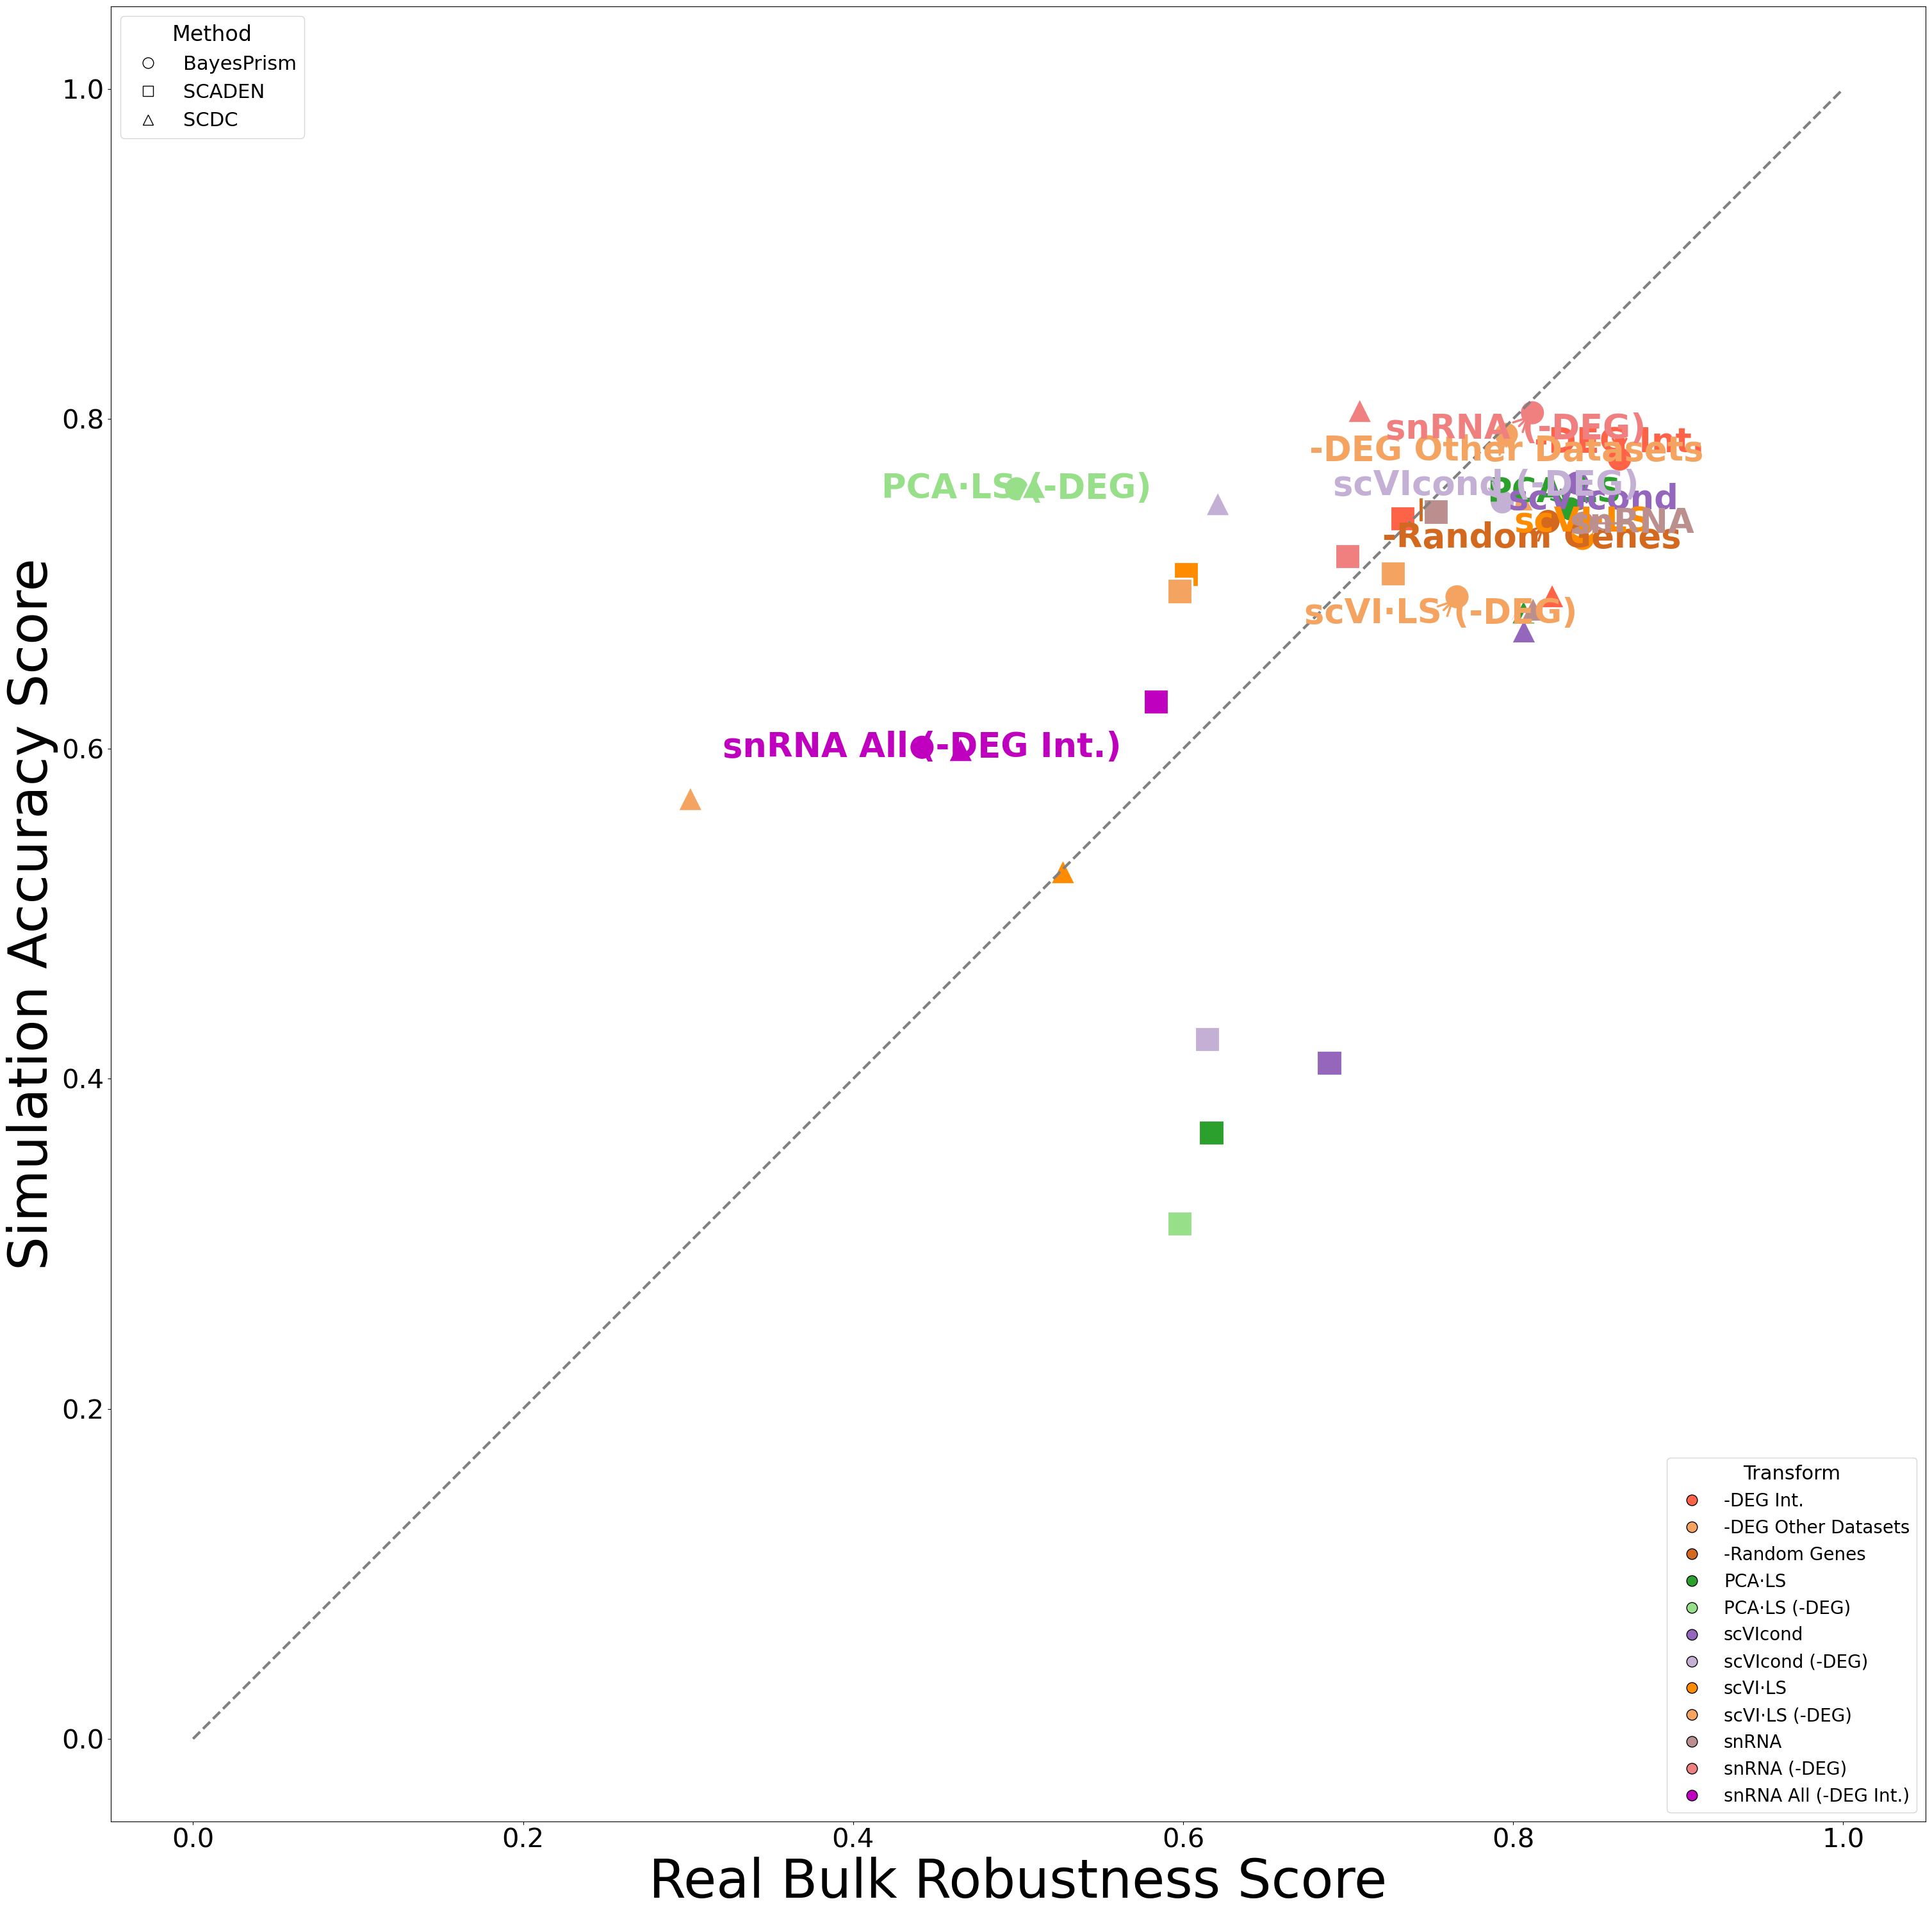

In [25]:
# Label offsets (same as before)
text_offsets = {
    "snRNA": (0.03, 0),
    "snRNA (-DEG)": (-0.01, -0.01),
    "-DEG Int.": (0, 0.01),
    "-DEG Other Datasets": (0, -0.01),
    "-Random Genes": (-0.01, -0.01),
    "PCA·LS": (-0.01, 0.01),
    "PCA·LS (-DEG)": (0, 0),
    "scVI·LS": (0, 0.01),
    "scVI·LS (-DEG)": (-0.01, -0.01),
    "scVIcond": (0.01, -0.01),
    "scVIcond (-DEG)": (-0.01, 0.01),
    "snRNA All (-DEG Int.)": (0, 0),
}

plt.figure(figsize=(32, 30))
ax = sns.scatterplot(
    data=combo_all,
    x="consistency_score",
    y="accuracy_score",
    hue="Display",      # color by transform
    style="Method",     # marker by method
    markers=method_markers,
    palette=display_palette,
    s=800,
)

# Annotate once per transform using BayesPrism point (if present), else first available
for disp, sub in combo_all.groupby("Display"):
    if "BayesPrism" in set(sub.Method):
        anchor = sub[sub.Method == "BayesPrism"].iloc[0]
    else:
        anchor = sub.iloc[0]
    x, y = anchor["consistency_score"], anchor["accuracy_score"]
    dx, dy = text_offsets.get(disp, (0.02, 0.02))
    ax.annotate(
        disp,
        xy=(x, y),
        xytext=(x + dx, y + dy),
        textcoords="data",
        ha="center",
        va="center",
        fontsize=38,
        color=display_palette.get(disp, "black"),
        weight="bold",
        arrowprops=dict(
            arrowstyle="->",
            color=display_palette.get(disp, "black"),
            lw=2.5,
            shrinkA=5,
            shrinkB=5,
        ),
    )

ax.plot([0, 1], [0, 1], "--", linewidth=3, color="gray")
ax.set_aspect("equal")
ax.set_xlabel("Real Bulk Robustness Score", fontsize=60)
ax.set_ylabel("Simulation Accuracy Score", fontsize=60)
ax.tick_params(axis="both", which="major", labelsize=30)

# Two legends: one for color (transforms), one for markers (methods)
handles, labels = ax.get_legend_handles_labels()
# seaborn mixes them; rebuild clean legends:
from collections import OrderedDict

# Color legend (Transforms)
color_items = OrderedDict()
for disp in combo_all["Display"].unique():
    color_items[disp] = plt.Line2D([0], [0], marker='o', linestyle='', markersize=12,
                                   markerfacecolor=display_palette.get(disp, "gray"),
                                   markeredgecolor='black')

# Marker legend (Methods)
marker_items = OrderedDict()
for m, mk in method_markers.items():
    marker_items[m] = plt.Line2D([0], [0], marker=mk, linestyle='', markersize=12,
                                 markerfacecolor="white", markeredgecolor='black')

leg1 = ax.legend(color_items.values(), color_items.keys(), title="Transform", loc="lower right", fontsize=20, title_fontsize=22, frameon=True)
ax.add_artist(leg1)
leg2 = ax.legend(marker_items.values(), marker_items.keys(), title="Method", loc="upper left", fontsize=22, title_fontsize=24, frameon=True)

plt.tight_layout()
plt.show()

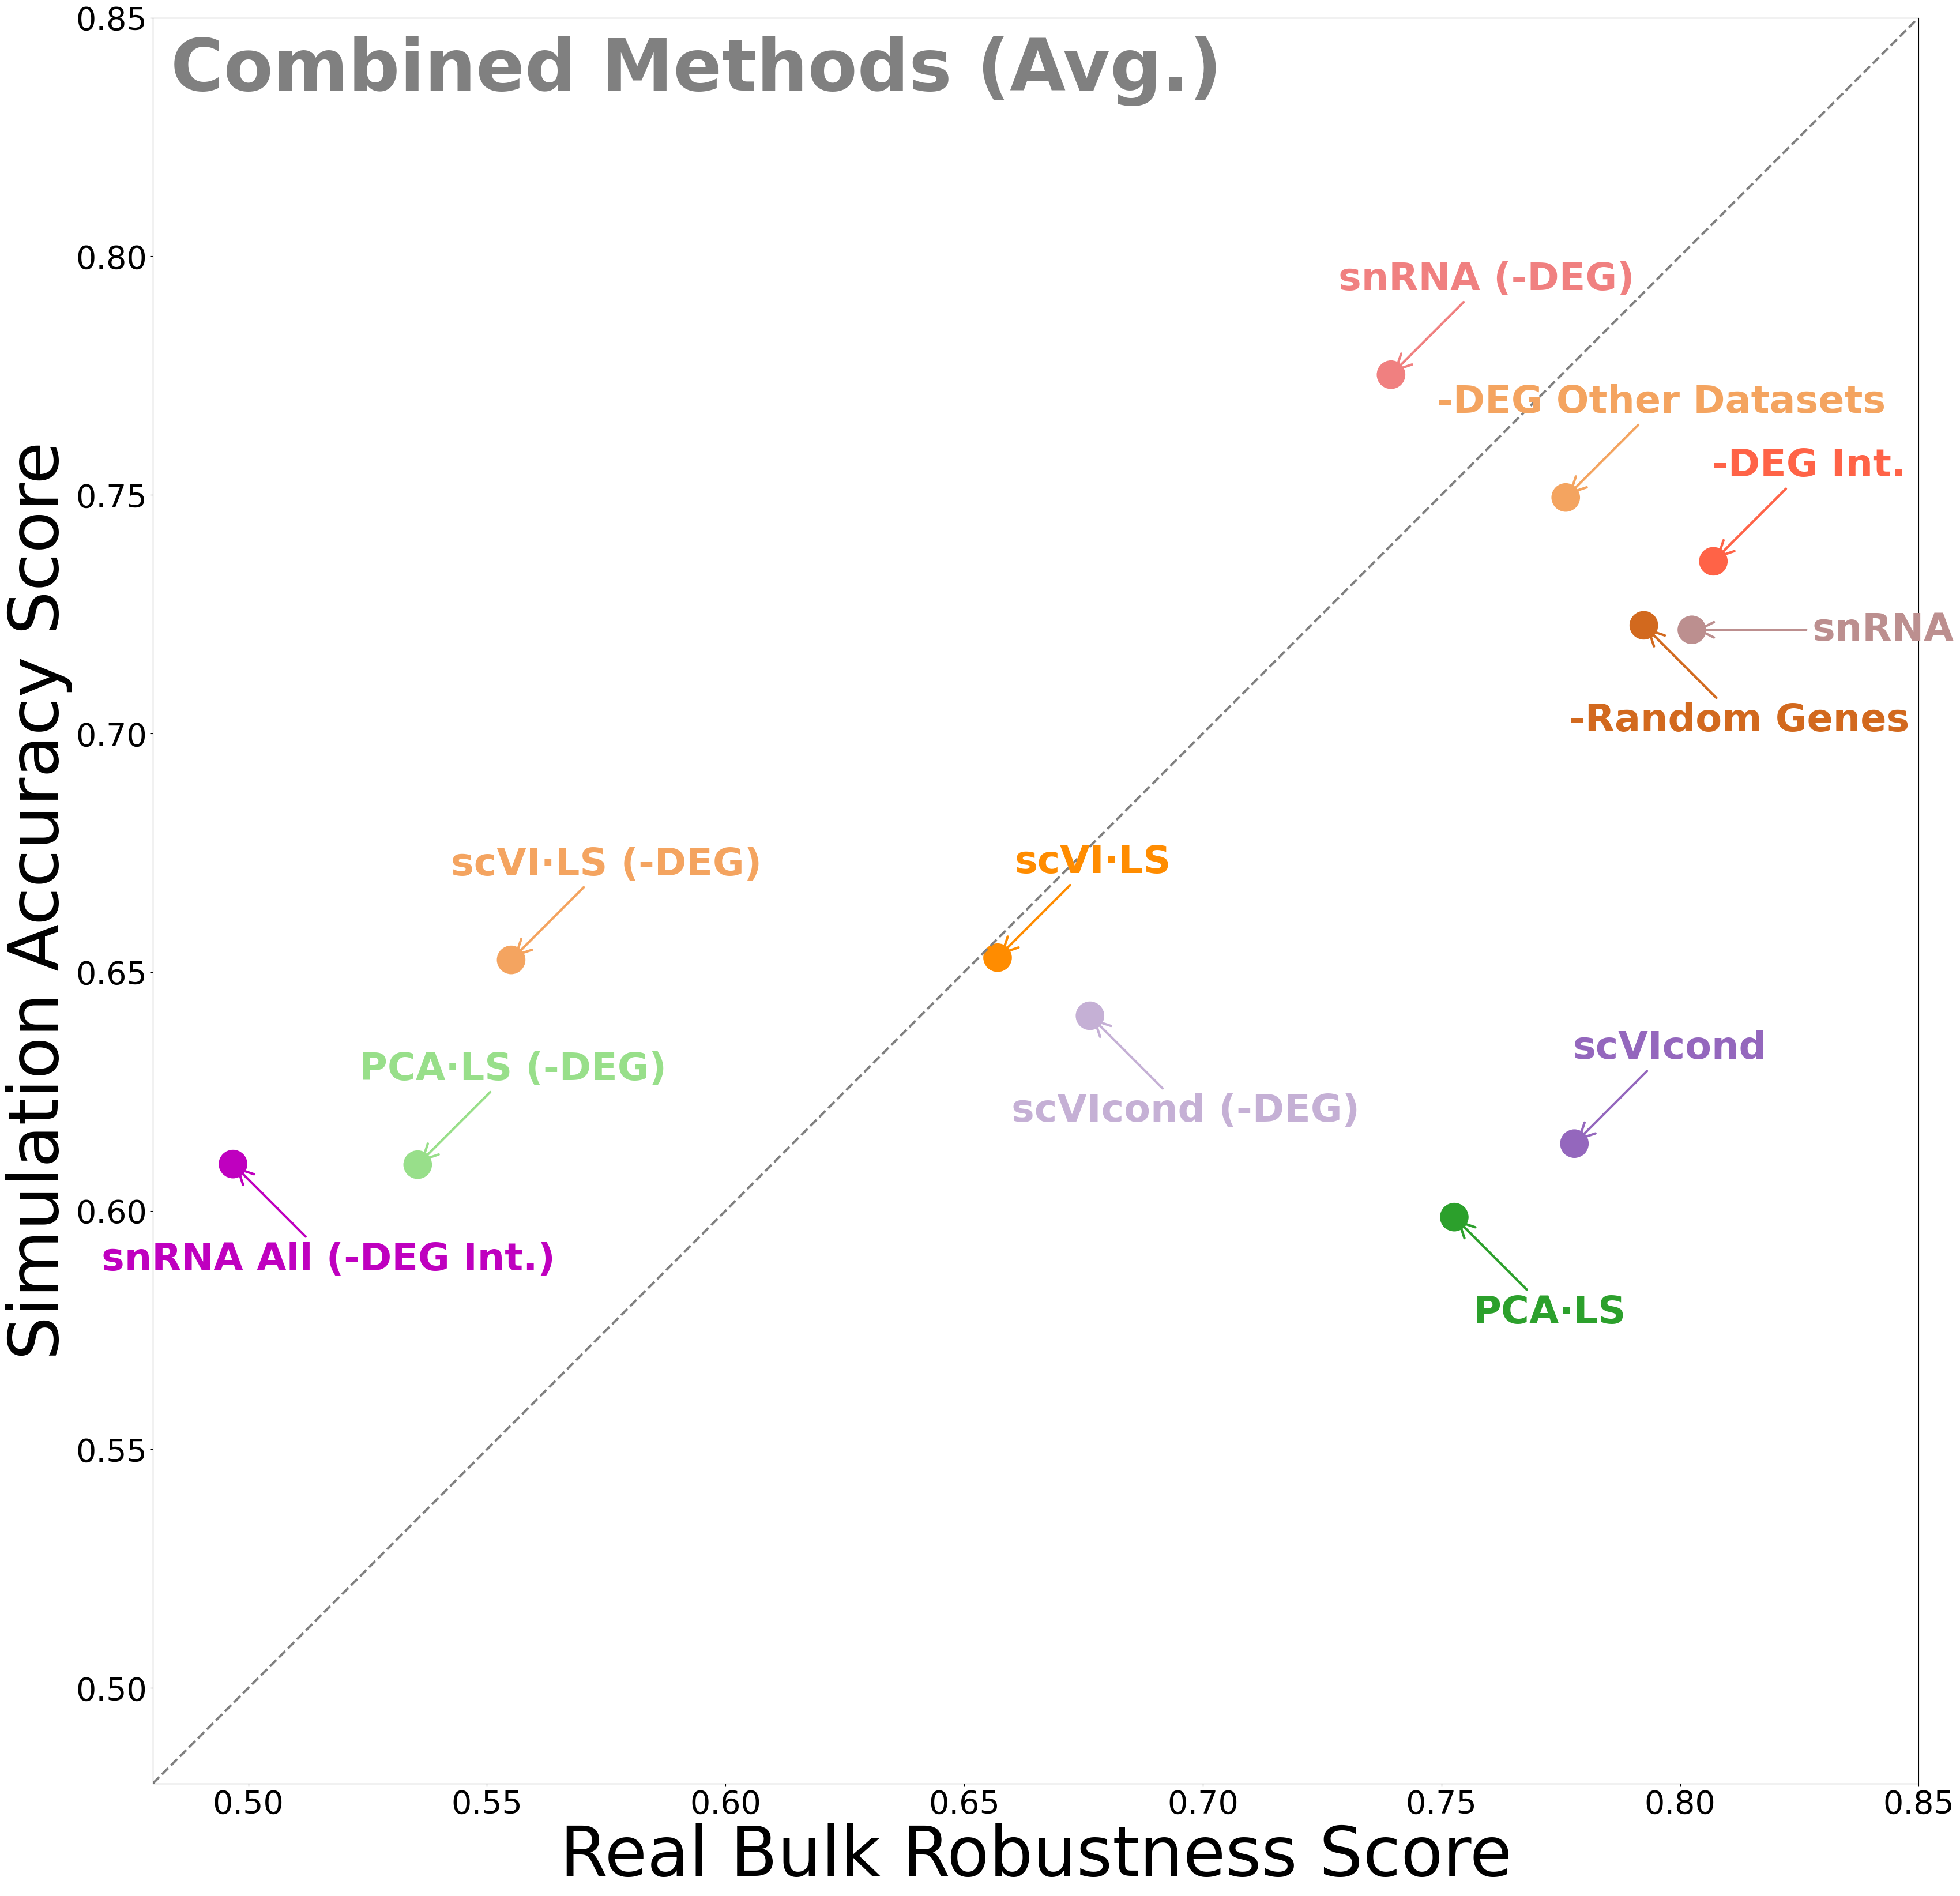

In [26]:
# =========================
# Average composite scores across methods (one point per transform)
# =========================
text_offsets = {
    "snRNA": (0.04, 0.0),
    "snRNA (-DEG)": (0.02, 0.02),
    "-DEG Int.":  (0.02, 0.02),
    "-DEG Other Datasets": (0.02, 0.02),
    "-Random Genes":  (0.02, -0.02),
    "PCA·LS":  (0.02, -0.02),
    "PCA·LS (-DEG)":  (0.02, 0.02),
    "scVI·LS":  (0.02, 0.02),
    "scVI·LS (-DEG)":  (0.02, 0.02),
    "scVIcond":  (0.02, 0.02),
    "scVIcond (-DEG)":  (0.02, -0.02),
    "snRNA All (-DEG Int.)":  (0.02, -.02),
}
# Compute mean consistency & accuracy per transform across methods
avg_by_transform = (
    combo_all
    .groupby("Display", as_index=False)[["consistency_score", "accuracy_score"]]
    .mean()
)

plt.figure(figsize=(34, 34))
ax = sns.scatterplot(
    data=avg_by_transform,
    x="consistency_score",
    y="accuracy_score",
    hue="Display",          # color by transform
    palette=display_palette,
    s=1500,                 # match marker size
    linewidth=3,            # match edge linewidth
    legend=False,           # no legend
)

# Annotate each transform using the averaged point
for _, row in avg_by_transform.iterrows():
    disp = row["Display"]
    x = row["consistency_score"]
    y = row["accuracy_score"]
    dx, dy = text_offsets.get(disp, (0.05, 0.05))  # match default offset style
    ax.annotate(
        disp,
        xy=(x, y),
        xytext=(x + dx, y + dy),
        textcoords="data",
        ha="center",
        va="center",
        fontsize=48,                            # match label fontsize
        color=display_palette.get(disp, "black"),
        weight="bold",
        arrowprops=dict(
            arrowstyle="->",
            color=display_palette.get(disp, "black"),
            lw=3,                               # match arrow linewidth
            shrinkA=5,
            shrinkB=5,
        ),
    )

# Diagonal reference line
ax.plot([0.48, 0.85], [0.48, 0.85], "--", linewidth=3, color="gray")

ax.set_aspect("equal")
ax.set_xlabel("Real Bulk Robustness Score", fontsize=86)
ax.set_ylabel("Simulation Accuracy Score", fontsize=86)
ax.tick_params(axis="both", which="major", labelsize=40)
ax.text(
    0.01, 0.99,                 # top-left corner in axis coordinates
    f"Combined Methods (Avg.)",                # text
    transform=ax.transAxes,     # use axis coordinate system
    fontsize=90,
    color="gray",
    va="top",                   # vertical alignment
    ha="left",                  # horizontal alignment
    weight="bold")
plt.ylim((0.48, 0.85))
plt.xlim((0.48, 0.85))
plt.tight_layout()
plt.show()
